# **CNN + RNN model**

# Load the data

In [1]:
!pip install kaggle
!kaggle datasets download -d landlord/handwriting-recognition
!unzip handwriting-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

# Import the libraries

In [1]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2024-06-08 12:13:01.035915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 12:13:05.092870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Clean the data

In [5]:
train = pd.read_csv('written_name_train_v2.csv')
validation = pd.read_csv('written_name_validation_v2.csv')

In [6]:
# Identify the number of NaNs in the dataset
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", validation['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [7]:
# Drop the NaNs from the dataset
train.dropna(axis=0, inplace=True)
validation.dropna(axis=0, inplace=True)

In [8]:
# Identify the number of unreadable images in the dataset
train_data = train[train['IDENTITY'] != 'UNREADABLE']
valid_data = validation[validation['IDENTITY'] != 'UNREADABLE']

In [9]:
# Convert the 'IDENTITY' column to uppercase
train_data['IDENTITY'] = train_data['IDENTITY'].str.upper()
valid_data['IDENTITY'] = valid_data['IDENTITY'].str.upper()

/tmp/ipykernel_17442/195899036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['IDENTITY'] = train_data['IDENTITY'].str.upper()
/tmp/ipykernel_17442/195899036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['IDENTITY'] = valid_data['IDENTITY'].str.upper()


In [10]:
# Reset the index of the data
train_data.reset_index(inplace = True, drop=True)
valid_data.reset_index(inplace = True, drop=True)

# Initiate Data Loader

In [12]:
# This class is used to create the dataset for the model
class DataGenerator(Dataset):
    """Character level dataset.
        
        Args:
            dataframe (pandas dataframe): Dataframe containing the image paths and corresponding labels
            path (str): Path to the images
            char_map (dict): Dictionary containing the mapping of characters to integers
            transform (callable, optional): Optional transform to be applied on a sample.
    
    """
    def __init__(self, dataframe, path, char_map, transform=None):
        self.dataframe = dataframe 
        self.path = path
        self.char_map = char_map
        self.transform = transform

    def __len__(self):
        return len(self.dataframe) # Return the number of samples in the dataset

    def __getitem__(self, idx):
        img_path = self.dataframe['FILENAME'].values[idx] # Get the image path
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE) # Read the image
        img = img / 255.0 # Normalize the image
        if self.transform:
            img = self.transform(img) # Apply the transformations to the image
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) # Convert the image to a tensor and add a channel dimension

        text = str(self.dataframe['IDENTITY'].values[idx]) # Get the corresponding label
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long) # Convert the label to a tensor
        return img, label # Return the image and the label, both in tensor format

In [13]:
# Create the character map for the dataset
characters = sorted(set("".join(train['IDENTITY'].astype(str)).upper()))
char_to_label = {char: idx for idx, char in enumerate(characters)} # Map characters to integers
label_to_char = {idx: char for char, idx in char_to_label.items()} # Map integers to characters

print(char_to_label)

{' ': 0, "'": 1, '-': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, '`': 29}


In [14]:
# Create the transformations to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor()
])

In [20]:
path_train = "train_v2/train/"
path_valid = "validation_v2/validation/"

In [21]:
train_dataset = DataGenerator(train_data,path_train,char_to_label) # Create the training dataset
valid_dataset = DataGenerator(valid_data,path_valid,char_to_label) # Create the validation dataset

In [22]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # Create the training dataloader
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False) # Create the validation dataloader

In [23]:
# Display the first batch of images and labels to check if the dataset is created correctly
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(images.shape) 
    print(labels.shape)  
    break  

Batch 0:
torch.Size([1, 1, 31, 284])
torch.Size([1, 8])


# Segment the images

In [24]:
def segment_words(image_tensor, label):
    """
    Given an image tensor and a label tensor, this function extracts letters from the image
    and returns a list of segmented letter images.

    Parameters
    ----------
    image_tensor : PyTorch tensor of the image to classify
    label : PyTorch tensor representing the word as a sequence of character numbers

    Returns
    -------
    list of numpy arrays: Each array represents a segmented letter image.
    """

    segmented_letters = []

    # Convert the image tensor to a NumPy array
    image = image_tensor.squeeze().numpy()
    image = (image * 255).astype('uint8')  # Assuming the tensor is normalized [0, 1]

    # Convert the image to grayscale if it's not already
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Apply threshold to binarize the image
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Convert the label tensor to a list of integers
    label_list = label.flatten().tolist()


    # Check if the number of contours matches the length of the label
    if len(contours) == len(label_list):
        # Iterate over the contours and extract each letter as a separate image
        for i, contour in enumerate(contours):
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Extract the letter
            letter_img = image[y:y+h, x:x+w]
            segmented_letters.append(letter_img)

    return segmented_letters

In [25]:
def resize_and_filter(segmented_letters, target_size=(10, 14)):
    """
    Resize segmented letter images to the target size while maintaining aspect ratio.
    Parameters
    ----------
    segmented_letters : list of PyTorch tensors
        Each tensor represents a segmented letter image.
    target_size : tuple, optional
        Target size for resizing the segmented letter images. Default is (10, 14).
    Returns
    -------
    list of PyTorch tensors: Each tensor represents a resized segmented letter image.
    """
    resized_letters = []

    for letter_img in segmented_letters:
        # Get the dimensions of the image
        height, width = letter_img.shape

        # Calculate the aspect ratio
        aspect_ratio = width / height

        # Determine new dimensions maintaining the aspect ratio
        if aspect_ratio > 1:  # Width is greater than height
            new_width = min(target_size[1], int(target_size[0] * aspect_ratio))
            new_height = min(target_size[0], int(new_width / aspect_ratio))
        else:  # Height is greater than or equal to width
            new_height = min(target_size[0], int(target_size[1] / aspect_ratio))
            new_width = min(target_size[1], int(new_height * aspect_ratio))

        # Ensure new_width and new_height are positive
        new_width = max(1, new_width)
        new_height = max(1, new_height)

        # Resize the image to new dimensions
        resized_img = cv2.resize(letter_img, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Create a blank white image of target size
        new_img = np.ones((target_size[0], target_size[1]), dtype=np.uint8) * 255

        # Calculate the offset to paste the resized image
        x_offset = (target_size[1] - new_width) // 2
        y_offset = (target_size[0] - new_height) // 2

        # Paste the resized image onto the blank white image
        new_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

        # Convert the cropped image back to a PyTorch tensor
        resized_tensor = torch.tensor(new_img, dtype=torch.float32)

        resized_letters.append(resized_tensor)

    return resized_letters


In [26]:
# Check the segmentation and resizing functions on a batch of images
for images, labels in train_loader:
    letters = segment_words(images, labels)
    if len(letters) == 0:
        continue
    else:
        break # Break the loop if at least one word is segmented
letters = resize_and_filter(letters)
print(letters!=0) # Check if the letters are segmented and resized correctly

True


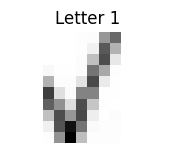

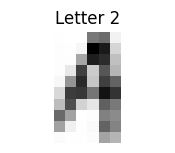

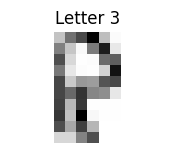

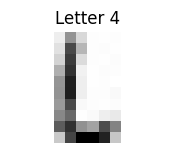

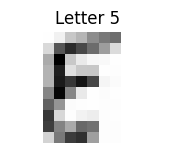

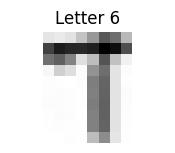

In [27]:
# Display the segmented and resized letters for the first word in the batch
num_letters = len(letters)

if num_letters == 0:
    print("No letters to display.")

for i, letter_img in enumerate(letters):
    plt.figure(figsize=(2, 2))
    plt.imshow(letter_img, cmap='gray')
    plt.title(f'Letter {i+1}')
    plt.axis('off')
    plt.show()

# Load the pre-trained CNN model

In [28]:
# Define SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 1 canal de color (grayscale) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
# Load your trained CNN model
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load('simple_cnn_model.pth'))
cnn_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=560, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=29, bias=True)
)

# Create SimpleLSTM model

In [30]:
# Define SimpleLSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device) # hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device) # internal state
        out, _ = self.lstm(x, (h_0, c_0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :]) # Return the last hidden state
        return out

In [31]:
# LSTM model parameters
input_size = 29  # This should match the CNN output size
hidden_size = 64 # Number of features in the hidden state
num_layers = 1   # Number of recurrent layers
output_size = 29  # Number of classes
lstm_model = SimpleLSTM(input_size, hidden_size, num_layers, output_size)

# Train the model

In [32]:
# Define loss and optimizer for LSTM
criterion = nn.CrossEntropyLoss() # Cross entropy loss
optimizer = optim.Adam(lstm_model.parameters(), lr=0.00005) # Adam optimizer

In [33]:
# Define constants
batch = 1
num_epochs = 60
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
test_losses = []  # List to store test losses
test_accuracies = []  # List to store test accuracies

In [35]:
for epoch in range(num_epochs):
    # Training
    lstm_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for images, labels in tqdm(train_loader, desc="Processing images"): # Use tqdm for a progress bar
        optimizer.zero_grad()  # Zero the parameter gradients

        for i, l in zip(images, labels):  # Iterate over the images and labels
            # Segment images
            segmented_images = resize_and_filter(segment_words(i, l))

            if len(segmented_images) == 0:
                continue  # Skip if no letters are segmented

            segmented_images_tensor = torch.stack(
                segmented_images)  # Convert the list to a tensor

            # Reshape the tensor with a batch size of 1
            # [batch_size, 1, embedding]
            segmented_images_tensor = segmented_images_tensor.view(segmented_images_tensor.size(
                0), 1, segmented_images_tensor.size(1), segmented_images_tensor.size(2))

            # CNN feature extraction
            with torch.no_grad():
                features = cnn_model(segmented_images_tensor)

            # Reshape features for LSTM
            features = features.view(-1, 1, features.size(1))

            # RNN
            outputs = lstm_model(features)  # Forward pass

            loss = criterion(outputs, l.view(-1))  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()

            running_loss += loss.item()  # Add the loss to the running loss
            _, predicted = torch.max(outputs, 1)  # Get the predicted labels
            total += l.size(0)  # Add the number of labels to the total
            # Add the number of correct predictions
            correct += (predicted == l.view(-1)).sum().item()

    # Calculate the epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    lstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    word_correct = 0
    word_total = 0
    letter_correct = 0
    letter_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            for i, l in zip(images, labels):
                segmented_images = resize_and_filter(segment_words(i, l))

                if len(segmented_images) == 0:
                    continue

                segmented_images_tensor = torch.stack(segmented_images)
                segmented_images = segmented_images_tensor.view(segmented_images_tensor.size(
                    0), 1, segmented_images_tensor.size(1), segmented_images_tensor.size(2))

                with torch.no_grad():
                    features = cnn_model(segmented_images)

                features = features.view(-1, 1, features.size(1))
                outputs = lstm_model(features)
                loss = criterion(outputs, l.view(-1))

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += l.size(0)
                correct += (predicted == l.view(-1)).sum().item()
                letter_total += l.size(0)
                letter_correct += (predicted == l.view(-1)).sum().item()
                
                if torch.equal(predicted, l.view(-1)):
                    word_correct += 1
                word_total += 1

    epoch_loss = running_loss / len(valid_loader)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    letter_accuracy = letter_correct / letter_total if letter_total > 0 else 0
    word_accuracy = word_correct / word_total if word_total > 0 else 0

    # Print the epoch loss and accuracy
    print(
        f"Epoch {epoch+1}/{num_epochs}, \nTrain Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, \n Test Loss: {test_losses[-1]:.4f},  Test Acc: {test_accuracies[-1]:.4f}\n")

# Save the trained model
torch.save(lstm_model.state_dict(), 'cnn_rnn_model.pth')

Processing images: 100%|██████████| 330294/330294 [36:40<00:00, 150.10it/s] 


Epoch 1/60, 
Train Loss: 0.1535, Train Acc: 0.7035, 
 Test Loss: 0.1036,  Test Acc: 0.7904



Processing images: 100%|██████████| 330294/330294 [07:08<00:00, 770.47it/s] 


Epoch 2/60, 
Train Loss: 0.0902, Train Acc: 0.8149, 
 Test Loss: 0.0868,  Test Acc: 0.8255



Processing images: 100%|██████████| 330294/330294 [07:18<00:00, 753.81it/s] 


Epoch 3/60, 
Train Loss: 0.0796, Train Acc: 0.8361, 
 Test Loss: 0.0800,  Test Acc: 0.8383



Processing images: 100%|██████████| 330294/330294 [07:07<00:00, 773.06it/s] 


Epoch 4/60, 
Train Loss: 0.0747, Train Acc: 0.8470, 
 Test Loss: 0.0753,  Test Acc: 0.8501



Processing images: 100%|██████████| 330294/330294 [07:13<00:00, 762.20it/s] 


Epoch 5/60, 
Train Loss: 0.0715, Train Acc: 0.8542, 
 Test Loss: 0.0735,  Test Acc: 0.8542



Processing images: 100%|██████████| 330294/330294 [07:14<00:00, 760.32it/s] 


Epoch 6/60, 
Train Loss: 0.0691, Train Acc: 0.8589, 
 Test Loss: 0.0713,  Test Acc: 0.8561



Processing images: 100%|██████████| 330294/330294 [07:59<00:00, 688.91it/s]


Epoch 7/60, 
Train Loss: 0.0672, Train Acc: 0.8624, 
 Test Loss: 0.0698,  Test Acc: 0.8602



Processing images: 100%|██████████| 330294/330294 [08:09<00:00, 675.32it/s]


Epoch 8/60, 
Train Loss: 0.0661, Train Acc: 0.8647, 
 Test Loss: 0.0691,  Test Acc: 0.8631



Processing images: 100%|██████████| 330294/330294 [08:10<00:00, 674.05it/s]


Epoch 9/60, 
Train Loss: 0.0650, Train Acc: 0.8671, 
 Test Loss: 0.0675,  Test Acc: 0.8640



Processing images: 100%|██████████| 330294/330294 [08:24<00:00, 654.12it/s]


Epoch 10/60, 
Train Loss: 0.0645, Train Acc: 0.8681, 
 Test Loss: 0.0665,  Test Acc: 0.8662



Processing images: 100%|██████████| 330294/330294 [08:03<00:00, 682.75it/s]


Epoch 11/60, 
Train Loss: 0.0632, Train Acc: 0.8701, 
 Test Loss: 0.0663,  Test Acc: 0.8672



Processing images: 100%|██████████| 330294/330294 [08:01<00:00, 685.90it/s]


Epoch 12/60, 
Train Loss: 0.0626, Train Acc: 0.8717, 
 Test Loss: 0.0648,  Test Acc: 0.8715



Processing images: 100%|██████████| 330294/330294 [07:55<00:00, 694.17it/s]


Epoch 13/60, 
Train Loss: 0.0621, Train Acc: 0.8731, 
 Test Loss: 0.0651,  Test Acc: 0.8712



Processing images: 100%|██████████| 330294/330294 [08:05<00:00, 680.95it/s]


Epoch 14/60, 
Train Loss: 0.0617, Train Acc: 0.8738, 
 Test Loss: 0.0645,  Test Acc: 0.8719



Processing images: 100%|██████████| 330294/330294 [07:58<00:00, 690.51it/s]


Epoch 15/60, 
Train Loss: 0.0613, Train Acc: 0.8748, 
 Test Loss: 0.0639,  Test Acc: 0.8731



Processing images: 100%|██████████| 330294/330294 [07:56<00:00, 692.78it/s]


Epoch 16/60, 
Train Loss: 0.0606, Train Acc: 0.8763, 
 Test Loss: 0.0632,  Test Acc: 0.8751



Processing images: 100%|██████████| 330294/330294 [08:16<00:00, 664.73it/s]


Epoch 17/60, 
Train Loss: 0.0603, Train Acc: 0.8771, 
 Test Loss: 0.0629,  Test Acc: 0.8749



Processing images: 100%|██████████| 330294/330294 [07:51<00:00, 700.78it/s]


Epoch 18/60, 
Train Loss: 0.0599, Train Acc: 0.8781, 
 Test Loss: 0.0625,  Test Acc: 0.8767



Processing images: 100%|██████████| 330294/330294 [07:54<00:00, 696.37it/s]


Epoch 19/60, 
Train Loss: 0.0595, Train Acc: 0.8789, 
 Test Loss: 0.0631,  Test Acc: 0.8750



Processing images: 100%|██████████| 330294/330294 [07:58<00:00, 690.41it/s]


Epoch 20/60, 
Train Loss: 0.0592, Train Acc: 0.8790, 
 Test Loss: 0.0619,  Test Acc: 0.8773



Processing images: 100%|██████████| 330294/330294 [07:34<00:00, 726.16it/s]


Epoch 21/60, 
Train Loss: 0.0589, Train Acc: 0.8798, 
 Test Loss: 0.0618,  Test Acc: 0.8771



Processing images: 100%|██████████| 330294/330294 [07:40<00:00, 716.56it/s]


Epoch 22/60, 
Train Loss: 0.0590, Train Acc: 0.8799, 
 Test Loss: 0.0619,  Test Acc: 0.8778



Processing images: 100%|██████████| 330294/330294 [07:44<00:00, 710.91it/s]


Epoch 23/60, 
Train Loss: 0.0585, Train Acc: 0.8809, 
 Test Loss: 0.0610,  Test Acc: 0.8784



Processing images: 100%|██████████| 330294/330294 [08:04<00:00, 681.46it/s]


Epoch 24/60, 
Train Loss: 0.0582, Train Acc: 0.8815, 
 Test Loss: 0.0604,  Test Acc: 0.8789



Processing images: 100%|██████████| 330294/330294 [07:49<00:00, 703.54it/s]


Epoch 25/60, 
Train Loss: 0.0580, Train Acc: 0.8817, 
 Test Loss: 0.0603,  Test Acc: 0.8801



Processing images: 100%|██████████| 330294/330294 [07:58<00:00, 689.66it/s]


Epoch 26/60, 
Train Loss: 0.0577, Train Acc: 0.8821, 
 Test Loss: 0.0605,  Test Acc: 0.8788



Processing images: 100%|██████████| 330294/330294 [08:12<00:00, 670.18it/s]


Epoch 27/60, 
Train Loss: 0.0572, Train Acc: 0.8830, 
 Test Loss: 0.0600,  Test Acc: 0.8818



Processing images: 100%|██████████| 330294/330294 [08:09<00:00, 675.29it/s]


Epoch 28/60, 
Train Loss: 0.0571, Train Acc: 0.8839, 
 Test Loss: 0.0597,  Test Acc: 0.8815



Processing images: 100%|██████████| 330294/330294 [08:00<00:00, 687.61it/s]


Epoch 29/60, 
Train Loss: 0.0570, Train Acc: 0.8840, 
 Test Loss: 0.0596,  Test Acc: 0.8817



Processing images: 100%|██████████| 330294/330294 [07:53<00:00, 697.82it/s]


Epoch 30/60, 
Train Loss: 0.0566, Train Acc: 0.8844, 
 Test Loss: 0.0589,  Test Acc: 0.8839



Processing images: 100%|██████████| 330294/330294 [08:12<00:00, 671.09it/s]


Epoch 31/60, 
Train Loss: 0.0564, Train Acc: 0.8855, 
 Test Loss: 0.0600,  Test Acc: 0.8809



Processing images: 100%|██████████| 330294/330294 [07:50<00:00, 701.59it/s]


Epoch 32/60, 
Train Loss: 0.0562, Train Acc: 0.8857, 
 Test Loss: 0.0588,  Test Acc: 0.8835



Processing images: 100%|██████████| 330294/330294 [07:53<00:00, 697.07it/s]


Epoch 33/60, 
Train Loss: 0.0563, Train Acc: 0.8856, 
 Test Loss: 0.0588,  Test Acc: 0.8858



Processing images: 100%|██████████| 330294/330294 [07:55<00:00, 694.59it/s]


Epoch 34/60, 
Train Loss: 0.0561, Train Acc: 0.8861, 
 Test Loss: 0.0594,  Test Acc: 0.8821



Processing images: 100%|██████████| 330294/330294 [07:52<00:00, 699.38it/s]


Epoch 35/60, 
Train Loss: 0.0556, Train Acc: 0.8867, 
 Test Loss: 0.0586,  Test Acc: 0.8854



Processing images: 100%|██████████| 330294/330294 [07:36<00:00, 723.98it/s]


Epoch 36/60, 
Train Loss: 0.0555, Train Acc: 0.8875, 
 Test Loss: 0.0587,  Test Acc: 0.8855



Processing images: 100%|██████████| 330294/330294 [07:51<00:00, 700.97it/s]


Epoch 37/60, 
Train Loss: 0.0554, Train Acc: 0.8872, 
 Test Loss: 0.0583,  Test Acc: 0.8861



Processing images: 100%|██████████| 330294/330294 [08:07<00:00, 677.52it/s]


Epoch 38/60, 
Train Loss: 0.0552, Train Acc: 0.8878, 
 Test Loss: 0.0586,  Test Acc: 0.8836



Processing images: 100%|██████████| 330294/330294 [08:00<00:00, 687.61it/s] 


Epoch 39/60, 
Train Loss: 0.0550, Train Acc: 0.8878, 
 Test Loss: 0.0584,  Test Acc: 0.8860



Processing images: 100%|██████████| 330294/330294 [07:59<00:00, 689.09it/s]


Epoch 40/60, 
Train Loss: 0.0550, Train Acc: 0.8880, 
 Test Loss: 0.0579,  Test Acc: 0.8877



Processing images: 100%|██████████| 330294/330294 [08:04<00:00, 681.86it/s]


Epoch 41/60, 
Train Loss: 0.0551, Train Acc: 0.8878, 
 Test Loss: 0.0581,  Test Acc: 0.8866



Processing images: 100%|██████████| 330294/330294 [08:07<00:00, 677.19it/s]


Epoch 42/60, 
Train Loss: 0.0547, Train Acc: 0.8883, 
 Test Loss: 0.0582,  Test Acc: 0.8854



Processing images: 100%|██████████| 330294/330294 [08:08<00:00, 676.38it/s]


Epoch 43/60, 
Train Loss: 0.0547, Train Acc: 0.8888, 
 Test Loss: 0.0579,  Test Acc: 0.8867



Processing images: 100%|██████████| 330294/330294 [08:08<00:00, 676.77it/s]


Epoch 44/60, 
Train Loss: 0.0544, Train Acc: 0.8897, 
 Test Loss: 0.0570,  Test Acc: 0.8884



Processing images: 100%|██████████| 330294/330294 [08:23<00:00, 656.60it/s]


Epoch 45/60, 
Train Loss: 0.0543, Train Acc: 0.8898, 
 Test Loss: 0.0571,  Test Acc: 0.8876



Processing images: 100%|██████████| 330294/330294 [08:11<00:00, 671.99it/s]


Epoch 46/60, 
Train Loss: 0.0546, Train Acc: 0.8893, 
 Test Loss: 0.0577,  Test Acc: 0.8864



Processing images: 100%|██████████| 330294/330294 [08:10<00:00, 673.29it/s]


Epoch 47/60, 
Train Loss: 0.0542, Train Acc: 0.8898, 
 Test Loss: 0.0573,  Test Acc: 0.8867



Processing images: 100%|██████████| 330294/330294 [08:11<00:00, 671.64it/s]


Epoch 48/60, 
Train Loss: 0.0541, Train Acc: 0.8896, 
 Test Loss: 0.0565,  Test Acc: 0.8883



Processing images: 100%|██████████| 330294/330294 [08:08<00:00, 676.53it/s]


Epoch 49/60, 
Train Loss: 0.0541, Train Acc: 0.8898, 
 Test Loss: 0.0575,  Test Acc: 0.8879



Processing images: 100%|██████████| 330294/330294 [07:43<00:00, 712.70it/s] 


Epoch 50/60, 
Train Loss: 0.0539, Train Acc: 0.8901, 
 Test Loss: 0.0571,  Test Acc: 0.8890



Processing images: 100%|██████████| 330294/330294 [08:09<00:00, 674.96it/s]


Epoch 51/60, 
Train Loss: 0.0540, Train Acc: 0.8902, 
 Test Loss: 0.0567,  Test Acc: 0.8877



Processing images: 100%|██████████| 330294/330294 [08:25<00:00, 654.02it/s]


Epoch 52/60, 
Train Loss: 0.0539, Train Acc: 0.8905, 
 Test Loss: 0.0564,  Test Acc: 0.8891



Processing images: 100%|██████████| 330294/330294 [07:46<00:00, 708.34it/s]


Epoch 53/60, 
Train Loss: 0.0537, Train Acc: 0.8910, 
 Test Loss: 0.0568,  Test Acc: 0.8879



Processing images: 100%|██████████| 330294/330294 [07:59<00:00, 689.42it/s]


Epoch 54/60, 
Train Loss: 0.0539, Train Acc: 0.8907, 
 Test Loss: 0.0565,  Test Acc: 0.8892



Processing images: 100%|██████████| 330294/330294 [07:43<00:00, 712.77it/s]


Epoch 55/60, 
Train Loss: 0.0536, Train Acc: 0.8911, 
 Test Loss: 0.0569,  Test Acc: 0.8889



Processing images: 100%|██████████| 330294/330294 [07:42<00:00, 714.05it/s]


Epoch 56/60, 
Train Loss: 0.0532, Train Acc: 0.8916, 
 Test Loss: 0.0570,  Test Acc: 0.8880



Processing images: 100%|██████████| 330294/330294 [07:55<00:00, 694.81it/s]


Epoch 57/60, 
Train Loss: 0.0534, Train Acc: 0.8911, 
 Test Loss: 0.0567,  Test Acc: 0.8897



Processing images: 100%|██████████| 330294/330294 [07:52<00:00, 699.64it/s]


Epoch 58/60, 
Train Loss: 0.0530, Train Acc: 0.8921, 
 Test Loss: 0.0564,  Test Acc: 0.8889



Processing images: 100%|██████████| 330294/330294 [08:11<00:00, 671.67it/s] 


Epoch 59/60, 
Train Loss: 0.0531, Train Acc: 0.8917, 
 Test Loss: 0.0564,  Test Acc: 0.8893



Processing images: 100%|██████████| 330294/330294 [07:45<00:00, 709.76it/s]


Epoch 60/60, 
Train Loss: 0.0530, Train Acc: 0.8920, 
 Test Loss: 0.0568,  Test Acc: 0.8891



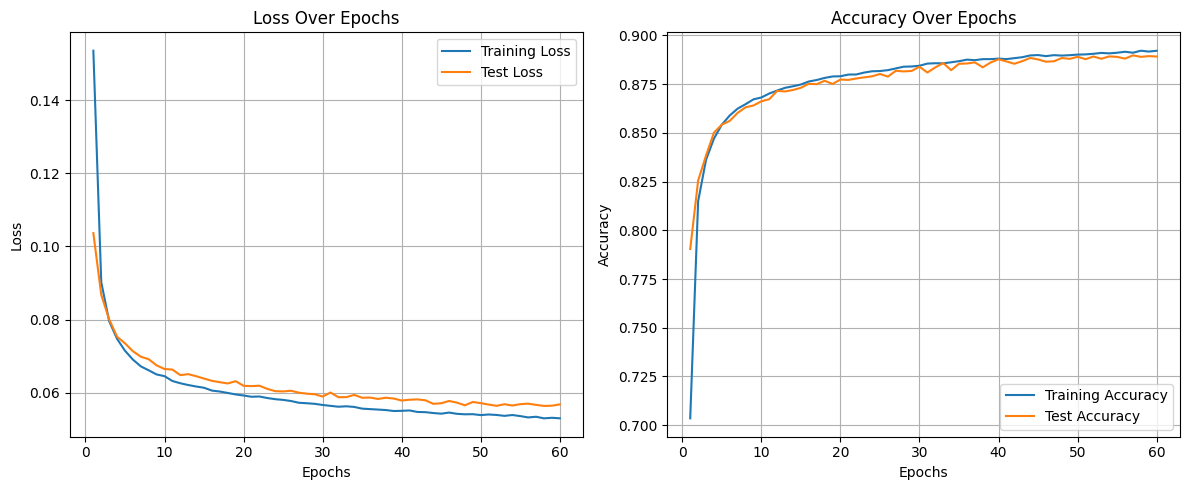

In [36]:
# Create loss and accuracy plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
# Càlcul de l'accuracy total al final de tot l'entrenament
lstm_model.eval()
correct = 0
total = 0
letter_correct = 0
letter_total = 0
word_correct = 0
word_total = 0

with torch.no_grad():
    for images, labels in valid_loader:
        for i, l in zip(images, labels):
            segmented_images = resize_and_filter(segment_words(i, l))

            if len(segmented_images) == 0:
                continue

            segmented_images_tensor = torch.stack(segmented_images)
            segmented_images_tensor = segmented_images_tensor.view(segmented_images_tensor.size(0), 1, segmented_images_tensor.size(1), segmented_images_tensor.size(2))

            with torch.no_grad():
                features = cnn_model(segmented_images_tensor)

            features = features.view(-1, 1, features.size(1))
            outputs = lstm_model(features)
            _, predicted = torch.max(outputs, 1)

            letter_total += l.size(0)
            letter_correct += (predicted == l.view(-1)).sum().item()

            if torch.equal(predicted, l.view(-1)):
                word_correct += 1
            word_total += 1  # Aquest increment ha de ser fora del if

# Calcular accuracies evitant la divisió per zero
letter_accuracy = letter_correct / letter_total if letter_total > 0 else 0
word_accuracy = word_correct / word_total if word_total > 0 else 0

print(f"Total Validation Letter Accuracy: {letter_accuracy*100:.4f}%")
print(f"Total Validation Word Accuracy: {word_accuracy*100:.4f}%")


Total Validation Letter Accuracy: 88.9106%
Total Validation Word Accuracy: 57.3154%
